# Plot & correlate time series

Here, we use weather and water data and compare them with the DSAR data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import scipy
import obspy.signal.filter

In [2]:
def feet2meters(column_in_feet):
    """
    Convert a Pandas DataFrame column from feet to meters.
    
    Parameters:
        column_in_feet (pandas.Series): The Pandas DataFrame column in feet.

    Returns:
        pandas.Series: The converted column in meters.
    """
    # Conversion factor: 1 foot = 0.3048 meters
    conversion_factor = 0.3048
    
    # Use the conversion factor to convert the column
    column_in_meters = column_in_feet * conversion_factor
    
    return column_in_meters

def inch2meters(column_in_inch):
    """
    Convert a Pandas DataFrame column from inches to meters.
    
    Parameters:
        column_in_inches (pandas.Series): The Pandas DataFrame column in inches.

    Returns:
        pandas.Series: The converted column in meters.
    """
    # Conversion factor: 1 inch = 0.0254 meters
    conversion_factor = 0.0254
    
    # Use the conversion factor to convert the column
    column_in_meters = column_in_inch * conversion_factor
    
    return column_in_meters

def fahrenheit2celsius(column_in_fahrenheit):
    """
    Convert degrees Fahrenheit to degrees Celsius.
    
    Parameters:
        degrees_fahrenheit (float or pandas.Series): Temperature in degrees Fahrenheit.

    Returns:
        float or pandas.Series: Temperature in degrees Celsius.
    """
    # Conversion formula: Celsius = (Fahrenheit - 32) * 5/9
    degrees_celsius = (column_in_fahrenheit - 32) * 5/9
    
    return degrees_celsius


In [3]:
def mask_df(row):
    peaks, properties = scipy.signal.find_peaks(row, prominence=(row.rolling('10D').median()*100).to_numpy(), distance=len(row))
    row_masked = row.copy()
    try:
#         row_masked[row_masked>min(row_masked.iloc[properties['left_bases'][0]:properties['right_bases'][0]])]=np.nan
        row_masked.iloc[properties['left_bases'][0]-500:properties['right_bases'][0]+500]=np.nan
    except:
        pass
    return row_masked

### Load DSAR data

In [4]:
sta = 'allUWsta' # allUWsta, YEL_VALT
# read seismic data -------------------------------------------------------------------------------------------------------------------
# df = pd.read_csv('../data/1980_{}_extended2.csv'.format(sta)) # 1 year long
df = pd.read_csv('../data/{}_extended2_long2.csv'.format(sta))
df.set_index('time',inplace=True)
df.index = pd.to_datetime(df.index).tz_localize(None)
df_read = df.resample('10min').median()

In [5]:
def head_and_tail(df, n=2): # function to show rows from the beginning and end of the df
    return pd.concat([df.head(n), df.tail(n)])

head_and_tail(df)

,rsam,mf,hf,dsar,ldsar,vsar,rms,rmes,pgv,pga,...,zsc2_ldsar,zsc2_vsar,zsc2_rms,zsc2_rmes,zsc2_pgv,zsc2_pga,lhdsar,lhvsar,zsc2_lhdsar,zsc2_lhvsar
time,,,,,,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 23:40:00,8.129698,11.363140,20.637913,1.403804,1.879541,0.666528,3.279763e-07,2.052415e-07,1.469808e-06,0.000122,...,0.726137,4.848894,0.603515,0.615680,0.657761,0.423246,2.726442,0.714780,1.454453,2.194831
2022-12-31 23:50:00,3.927294,6.949612,13.281453,1.103715,1.118566,0.574990,1.165115e-07,5.650548e-08,6.269962e-07,0.000029,...,0.508880,4.595204,0.048988,0.032803,0.063107,0.040983,1.350959,0.374586,0.835660,1.885521


In [8]:
# preprocess seismic data -------------------------------------------------------------------------------------------------------------------
df = df_read.copy()
df = df.apply(mask_df,axis=0) # remove outliers (the peak detection does not work well)

df = df.rolling('10D', center=True).median()
# df = df.rolling('1H').median()
# df = df.rolling('6H', center=True, closed='both').median()
# df = df[df.index<datetime.datetime(year,5,22)]

### Load Weater & Water data

In [9]:
lakelevel = pd.read_csv('/home/koepflma/project1/Mt-St-Helens/MtStHelens_activity/lakelevel.csv', index_col='Date', parse_dates=True)
ll_meters = feet2meters(lakelevel['LakeLevel(feet)'])
lakelevel['LakeLevel(meter)'] = ll_meters
lakelevel['rel_LakeLevel(meter)'] = lakelevel['LakeLevel(meter)'] - min(lakelevel['LakeLevel(meter)'])
lakelevel

,LakeLevel(feet),LakeLevel(meter),rel_LakeLevel(meter)
Date,,,
2000-01-01,3444.64,1049.926272,2.121408
2000-01-02,3444.61,1049.917128,2.112264
2000-01-03,3444.53,1049.892744,2.087880
2000-01-04,3444.65,1049.929320,2.124456
2000-01-05,3444.60,1049.914080,2.109216
...,...,...,...
2023-12-22,3444.62,1049.920176,2.115312
2023-12-23,3444.55,1049.898840,2.093976
2023-12-24,3444.51,1049.886648,2.081784


In [10]:
borehole = pd.read_csv('/home/koepflma/project1/Mt-St-Helens/MtStHelens_activity/Water_level_depth_LSD.csv',
                        skiprows=14, index_col='ISO 8601 UTC', parse_dates=True)
borehole_meters = feet2meters(borehole['Value'])
borehole['borehole(meter)'] = borehole_meters
borehole['rel_borehole(meter)'] = max(borehole['borehole(meter)']) - borehole['borehole(meter)']
borehole['rel_borehole(meter)'] = borehole['rel_borehole(meter)']+1
borehole

,Timestamp (UTC-08:00),Value,Approval Level,Grade,Qualifiers,borehole(meter),rel_borehole(meter)
ISO 8601 UTC,,,,,,,
2019-11-21 21:00:00+00:00,2019-11-21 13:00:00,41.980000,Working,50.0,NaN,12.795504,1.356746
2019-11-21 21:15:00+00:00,2019-11-21 13:15:00,41.990029,Working,50.0,NaN,12.798561,1.353690
2019-11-21 21:30:00+00:00,2019-11-21 13:30:00,41.990057,Working,50.0,NaN,12.798569,1.353681
2019-11-21 21:45:00+00:00,2019-11-21 13:45:00,41.990086,Working,50.0,NaN,12.798578,1.353672
2019-11-21 22:00:00+00:00,2019-11-21 14:00:00,42.000115,Working,50.0,NaN,12.801635,1.350615
...,...,...,...,...,...,...,...
2024-01-18 23:45:00+00:00,2024-01-18 15:45:00,33.360000,Working,50.0,NaN,10.168128,3.984122
2024-01-19 00:00:00+00:00,2024-01-18 16:00:00,33.350000,Working,50.0,NaN,10.165080,3.987170
2024-01-19 00:15:00+00:00,2024-01-18 16:15:00,33.360000,Working,50.0,NaN,10.168128,3.984122


In [11]:
weather = pd.read_csv('/home/koepflma/project1/Mt-St-Helens/MtStHelens_activity/usda_mt_st_helens_weather.csv',
                     skiprows=60, index_col='Date', parse_dates=True)
# Add 8 hours to the index local to UTC
weather.index = weather.index + pd.Timedelta(hours=8)
SWE_meters = inch2meters(weather['Snow Water Equivalent (in)'])
SDE_meters = inch2meters(weather['Snow Depth (in)'])
pre_meters = inch2meters(weather['Precipitation Accumulation (in)'])
temp_meters = fahrenheit2celsius(weather['Air Temperature Observed (degF)'])

weather['Snow Water Equivalent (m)'] = SWE_meters
weather['Snow Water Equivalent (m)'] = weather['Snow Water Equivalent (m)'].mask(weather['Snow Water Equivalent (m)'] < 0, np.nan)
weather['Snow Depth (m)'] = SDE_meters
weather['Snow Depth (m)'] = weather['Snow Depth (m)'].mask(weather['Snow Depth (m)'] < 0, np.nan)
weather['Precipitation Accumulation (m)'] = pre_meters
weather['Air Temperature Observed (degC)'] = temp_meters

weather

,Snow Water Equivalent (in),Snow Depth (in),Precipitation Accumulation (in),Air Temperature Observed (degF),Snow Water Equivalent (m),Snow Depth (m),Precipitation Accumulation (m),Air Temperature Observed (degC)
Date,,,,,,,,
2002-08-13 08:00:00,0.0,NaN,0.0,NaN,0.00000,NaN,0.00000,NaN
2002-08-13 22:00:00,0.0,-1.0,0.0,106.2,0.00000,NaN,0.00000,41.222222
2002-08-13 23:00:00,0.1,-1.0,0.1,99.7,0.00254,NaN,0.00254,37.611111
2002-08-14 00:00:00,0.1,-1.0,0.1,98.4,0.00254,NaN,0.00254,36.888889
2002-08-14 01:00:00,0.1,-1.0,0.1,95.9,0.00254,NaN,0.00254,35.500000
...,...,...,...,...,...,...,...,...
2023-11-28 13:00:00,10.8,7.0,47.8,37.0,0.27432,0.1778,1.21412,2.777778
2023-11-28 14:00:00,10.9,7.0,47.8,33.8,0.27686,0.1778,1.21412,1.000000
2023-11-28 15:00:00,10.9,7.0,47.8,34.5,0.27686,0.1778,1.21412,1.388889


### Plot

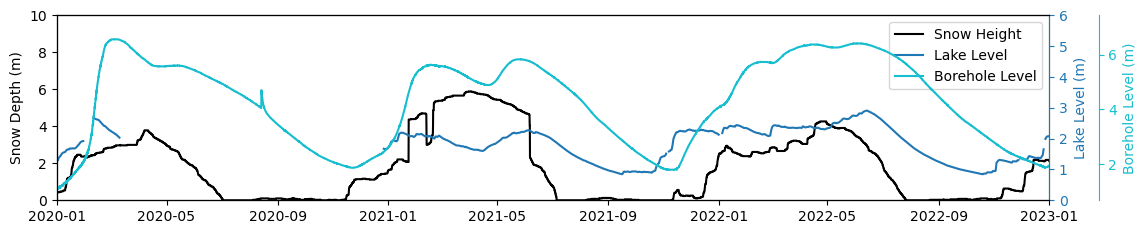

In [10]:
# crate figure lake level--------------------------------------------------------------------------------------------------------------------------
fig, (ax2) = plt.subplots(1,1, sharex=True, figsize=(6.4*2, 4.8*0.5))

ax2.plot(weather['Snow Depth (m)'].rolling('10D').median(), label ='Snow Height', alpha=1, color='k')
ax2.plot(np.nan, label='Lake Level', alpha=1, color='C0')
ax2.plot(np.nan, label='Borehole Level', alpha=1, color='C9')
ax22 = ax2.twinx()
ax22.plot(lakelevel['rel_LakeLevel(meter)'], label ='Lake Level', alpha=1, color='C0')
ax222 = ax2.twinx()
ax222.plot(borehole['rel_borehole(meter)'], label ='Borehole Level', alpha=1, color='C9')

# color ticks and spines
ax22.spines['right'].set_color('C0')
ax22.xaxis.label.set_color('C0')
ax22.tick_params(axis='y', colors='C0')

ax222.spines.right.set_position(("axes", 1.05))
ax222.spines['right'].set_color('C9')
ax222.xaxis.label.set_color('C9')
ax222.tick_params(axis='y', colors='C9')

    
# title, legende, and scale ------------------------------------------------------------------------------------------------------------
# ax1.set_title('Station {}'.format(sta))
# ax1.legend(loc='center left')
ax2.legend(loc='upper right')

# linear y-axis
ax2.set_ylabel('Snow Depth (m)')
ax2.set_ylim(0,10)
ax22.set_ylabel('Lake Level (m)', color='C0')
ax22.set_ylim(0,6)
ax222.set_ylabel('Borehole Level (m)', color='C9')


ax2.set_xlim(datetime.datetime(2020,1,1), datetime.datetime(2023,1,1))

fig.show()

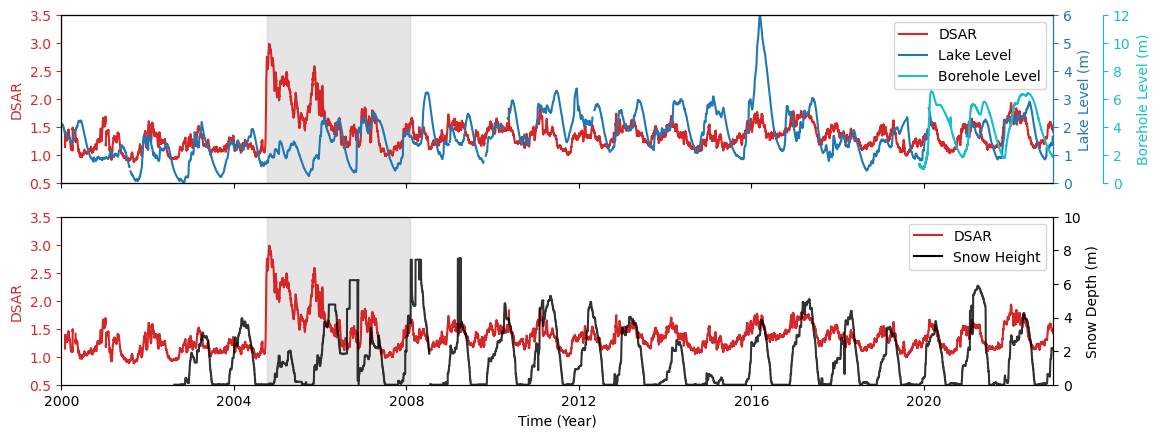

In [15]:
# crate figure lake level--------------------------------------------------------------------------------------------------------------------------
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, figsize=(6.4*2, 4.8))

# start plototting seismic data ---------------------------------------------------------------------------------------------------------
ax1.plot(df['dsar'], label='DSAR', alpha=1, color='C3')
ax1.plot(np.nan, label='Lake Level', alpha=1, color='C0')
ax1.plot(np.nan, label='Borehole Level', alpha=1, color='C9')
ax11 = ax1.twinx()
ax11.plot(lakelevel['rel_LakeLevel(meter)'], label ='Lake Level', alpha=1, color='C0')
ax111 = ax1.twinx()
ax111.plot(borehole['rel_borehole(meter)'], label ='Borehole Level', alpha=1, color='C9')

ax2.plot(df['dsar'], label='DSAR', alpha=1, color='C3')
ax2.plot(np.nan, label ='Snow Height', alpha=1, color='k')
ax22 = ax2.twinx()
ax22.plot(weather['Snow Depth (m)'].rolling('10D').median(), label ='Snow Height', alpha=0.8, color='k')

# color ticks and spines subplot 1
ax1.spines['left'].set_color('C3')
ax1.xaxis.label.set_color('C3')
ax1.tick_params(axis='y', colors='C3')

ax11.spines['right'].set_color('C0')
ax11.xaxis.label.set_color('C0')
ax11.tick_params(axis='y', colors='C0')

ax111.spines.right.set_position(("axes", 1.05))
ax111.spines['right'].set_color('C9')
ax111.xaxis.label.set_color('C9')
ax111.tick_params(axis='y', colors='C9')

# color ticks and spines subplot 2
ax2.spines['left'].set_color('C3')
ax2.xaxis.label.set_color('C3')
ax2.tick_params(axis='y', colors='C3')

ax22.spines['right'].set_color('k')
ax22.xaxis.label.set_color('k')
ax22.tick_params(axis='y', colors='k')


# plot dome periodes ------------------------------------------------------------------------------------------------------------------
# color = cm.gray(np.linspace(0, 1, len(activity_dome_start)+2))

# for i in range(len(activity_dome_start)):
#     sdate = activity_dome_start.index[i].to_pydatetime() # start date
#     edate = activity_dome_end.index[i].to_pydatetime() # end date
#     ax2.axvspan(sdate, edate, alpha=0.25, color=color[i])

sdate = datetime.datetime(2004,10,11)
edate = datetime.datetime(2008,2,1)
ax1.axvspan(sdate, edate, alpha=0.2, color='gray')
ax2.axvspan(sdate, edate, alpha=0.2, color='gray')
    
# title, legende, and scale ------------------------------------------------------------------------------------------------------------
# ax1.set_title('Station {}'.format(sta))
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')

# linear y-axis
ax1.set_ylabel('DSAR', color='C3')
ax1.set_ylim(0.5,3.5)
ax11.set_ylabel('Lake Level (m)', color='C0')
ax11.set_ylim(0,6)
ax111.set_ylabel('Borehole Level (m)', color='C9')
ax111.set_ylim(0,12)
ax2.set_ylabel('DSAR', color='C3')
ax2.set_ylim(0.5,3.5)
ax22.set_ylabel('Snow Depth (m)', color='k')
ax22.set_ylim(0,10)

ax2.set_xlim(df.index[0], df.index[-1])
ax2.set_xlabel('Time (Year)', color='k')
# ax2.set_xlim(datetime.datetime(2010,1,1), datetime.datetime(2023,1,1))

# import matplotlib.dates as mdates
# formatter = mdates.DateFormatter("%Y") ### formatter of the date
# locator = mdates.YearLocator() ### where to put the labels

# ax2.xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
# ax2.xaxis.set_major_locator(locator)

# save plot and show -----------------------------------------------------------------------------------------------------------------
# plt.savefig('../plots/multiyear/multi_sta/water_snow_DSAR_{}_lin_long_dome_roll10D_final.png'.format(sta), dpi=300, bbox_inches='tight')
# plt.savefig('../plots/multiyear/single_sta/waterlevel2_DSAR_{}_lin_zoom_dome_roll10D.png'.format(sta), dpi=300, bbox_inches='tight')
fig.show()

### Drop NaN & cut timeseries

In [59]:
dsar_copy = df['dsar'].copy()
lake_copy = lakelevel['rel_LakeLevel(meter)'].copy()
borehole_copy = borehole['rel_borehole(meter)'].copy()
snow_copy = weather['Snow Depth (m)'].copy()

# drop all nan rows
dsar_copy = dsar_copy.dropna()
lake_copy = lake_copy.dropna()
borehole_copy = borehole_copy.dropna()
snow_copy = snow_copy.dropna()

In [60]:
# values belonging to first parameter, second for length
dsar_lake = dsar_copy.loc[min(min(dsar_copy.index),min(lake_copy.index)):max(max(dsar_copy.index),max(lake_copy.index))]
lake_dsar = lake_copy.loc[min(min(dsar_copy.index),min(lake_copy.index)):max(max(dsar_copy.index),max(lake_copy.index))]


time
2000-02-05 20:00:00    1.199354
2000-02-05 20:10:00    1.174137
2000-02-05 20:20:00    1.148920
2000-02-05 20:30:00    1.143881
2000-02-05 20:40:00    1.138842
                         ...   
2022-12-31 23:10:00    1.459021
2022-12-31 23:20:00    1.458979
2022-12-31 23:30:00    1.458907
2022-12-31 23:40:00    1.458907
2022-12-31 23:50:00    1.458907
Name: dsar, Length: 1200682, dtype: float64

In [ ]:
cut_df = your_dataframe.loc[min_index:max_index]

### Same sampling rate

In [46]:
weather['Snow Depth (m)']
df['dsar']

time
2000-01-01 00:00:00         NaN
2000-01-01 00:10:00         NaN
2000-01-01 00:20:00         NaN
2000-01-01 00:30:00         NaN
2000-01-01 00:40:00         NaN
                         ...   
2022-12-31 23:10:00    1.459021
2022-12-31 23:20:00    1.458979
2022-12-31 23:30:00    1.458907
2022-12-31 23:40:00    1.458907
2022-12-31 23:50:00    1.458907
Freq: 10T, Name: dsar, Length: 1209744, dtype: float64

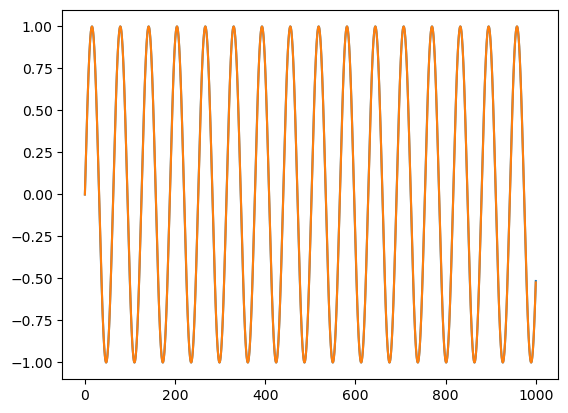

In [19]:
# Abstract example
t1 = np.arange(0,1e3,1/10.) # 10Hz sampling
t2 = np.arange(0,1e3,1/5.) # 5Hz sampling

x = np.sin(t1/10)
y = np.sin(t2/10)

plt.plot(t1,x)
plt.plot(t2,y)

True

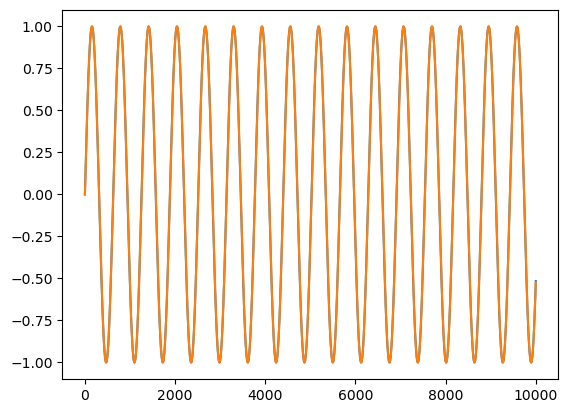

In [23]:
y_int = np.interp(t1, t2, y)

plt.plot(x)
plt.plot(y_int)

len(x) == len(y_int)

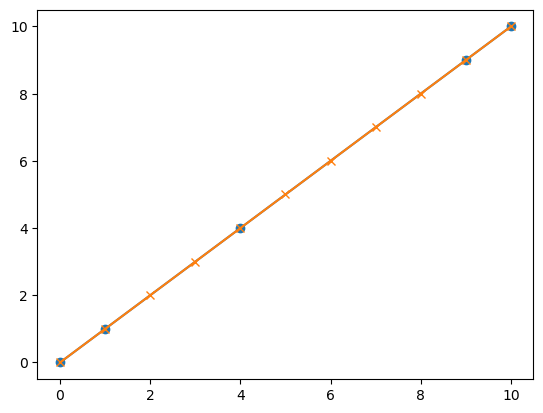

In [45]:
x = np.array([0,1,4,9,10])
y = x.copy()
x1 = np.arange(0,11)
y1 = np.interp(x1, x,y)
plt.plot(x,y, marker='o')
plt.plot(x1, y1, marker='x')

### Normalize

In [ ]:
# x-mean/std

### Cross-correlate

In [ ]:
# obspy.signal.cross_correlation.correlate

In [ ]:
# loop ower slices and correleate
# search max value and max index of cc output

## Cross-correlation

In [185]:
# Define parameters for sine waves
n_years = 10
num_points = [365*10, 365*10, 365*5]  # Assuming one year of data
freq = [10.,10.,5.,]  # Frequency for the sine waves
time_shifts = [0, 0, 0]  # Different time shifts for the sine waves
additional_amplitude = 0.1  # Amplitude of the additional sine wave

# Generate time series data
time_series_data = {}
for i in range(len(num_points)):
    time = pd.date_range(start=f'2010-0{i+1}-01', periods=num_points[i])
    main_values = np.sin(2 * np.pi * freq[i] * (np.arange(num_points[i]) / num_points[i] - time_shifts[i] / num_points[i]))
#     additional_values = additional_amplitude * np.sin(2 * np.pi * 100. * (np.arange(num_points[i]) / num_points[i]))
    values = main_values #+ additional_values
    time_series_data[f'ts{i+1}'] = pd.Series(values, index=time)
time_series_data    

{'ts1': 2010-01-01    0.000000
 2010-01-02    0.017213
 2010-01-03    0.034422
 2010-01-04    0.051620
 2010-01-05    0.068802
                 ...   
 2019-12-25   -0.085965
 2019-12-26   -0.068802
 2019-12-27   -0.051620
 2019-12-28   -0.034422
 2019-12-29   -0.017213
 Freq: D, Length: 3650, dtype: float64,
 'ts2': 2010-02-01    0.000000
 2010-02-02    0.017213
 2010-02-03    0.034422
 2010-02-04    0.051620
 2010-02-05    0.068802
                 ...   
 2020-01-25   -0.085965
 2020-01-26   -0.068802
 2020-01-27   -0.051620
 2020-01-28   -0.034422
 2020-01-29   -0.017213
 Freq: D, Length: 3650, dtype: float64,
 'ts3': 2010-03-01    0.000000
 2010-03-02    0.017213
 2010-03-03    0.034422
 2010-03-04    0.051620
 2010-03-05    0.068802
                 ...   
 2015-02-23   -0.085965
 2015-02-24   -0.068802
 2015-02-25   -0.051620
 2015-02-26   -0.034422
 2015-02-27   -0.017213
 Freq: D, Length: 1825, dtype: float64}

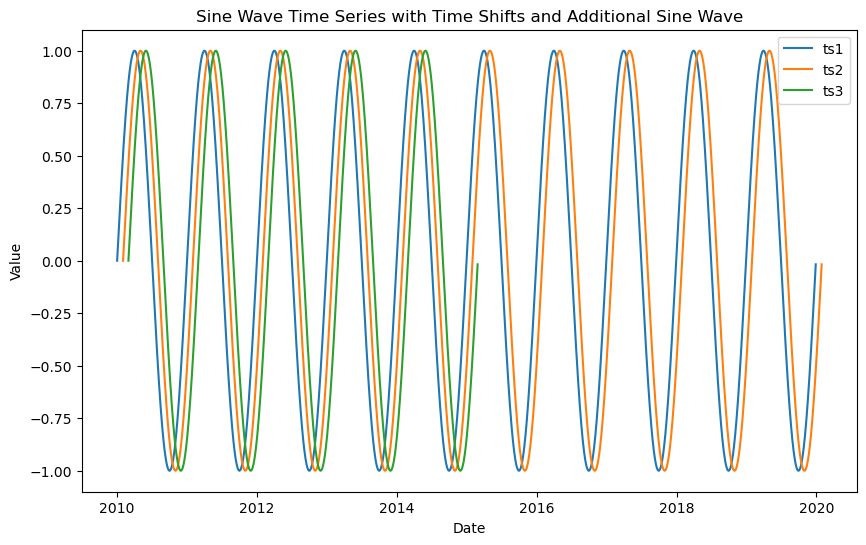

In [186]:
# Plot each time series
plt.figure(figsize=(10, 6))
for name, series in time_series_data.items():
    plt.plot(series.index, series.values, label=name)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Sine Wave Time Series with Time Shifts and Additional Sine Wave')
plt.legend()
plt.show()

In [28]:
df['dsar']

time
2000-01-01 00:00:00         NaN
2000-01-01 00:10:00         NaN
2000-01-01 00:20:00         NaN
2000-01-01 00:30:00         NaN
2000-01-01 00:40:00         NaN
                         ...   
2022-12-31 23:10:00    1.459021
2022-12-31 23:20:00    1.458979
2022-12-31 23:30:00    1.458907
2022-12-31 23:40:00    1.458907
2022-12-31 23:50:00    1.458907
Freq: 10T, Name: dsar, Length: 1209744, dtype: float64

In [27]:
lakelevel['rel_LakeLevel(meter)']

Date
2000-01-01    2.121408
2000-01-02    2.112264
2000-01-03    2.087880
2000-01-04    2.124456
2000-01-05    2.109216
                ...   
2023-12-22    2.115312
2023-12-23    2.093976
2023-12-24    2.081784
2023-12-25    2.081784
2023-12-26    2.066544
Name: rel_LakeLevel(meter), Length: 8761, dtype: float64

In [29]:
borehole['rel_borehole(meter)']

ISO 8601 UTC
2019-11-21 21:00:00+00:00    1.356746
2019-11-21 21:15:00+00:00    1.353690
2019-11-21 21:30:00+00:00    1.353681
2019-11-21 21:45:00+00:00    1.353672
2019-11-21 22:00:00+00:00    1.350615
                               ...   
2024-01-18 23:45:00+00:00    3.984122
2024-01-19 00:00:00+00:00    3.987170
2024-01-19 00:15:00+00:00    3.984122
2024-01-19 00:30:00+00:00    3.974978
2024-01-19 00:45:00+00:00    3.981074
Name: rel_borehole(meter), Length: 145431, dtype: float64

In [30]:
weather['Snow Depth (m)']

Date
2002-08-13 08:00:00       NaN
2002-08-13 22:00:00       NaN
2002-08-13 23:00:00       NaN
2002-08-14 00:00:00       NaN
2002-08-14 01:00:00       NaN
                        ...  
2023-11-28 13:00:00    0.1778
2023-11-28 14:00:00    0.1778
2023-11-28 15:00:00    0.1778
2023-11-28 16:00:00    0.1778
2023-11-28 17:00:00    0.2032
Name: Snow Depth (m), Length: 186499, dtype: float64

In [190]:
time_series_data = {
    'dsar': df['dsar'],
    'lakelevel': lakelevel['rel_LakeLevel(meter)'],
#     'borehole': borehole['rel_borehole(meter)'],
#     'weater': weather['Snow Depth (m)']
}
time_series_data

{'dsar': time
 2000-01-01 00:00:00         NaN
 2000-01-01 00:10:00         NaN
 2000-01-01 00:20:00         NaN
 2000-01-01 00:30:00         NaN
 2000-01-01 00:40:00         NaN
                          ...   
 2022-12-31 23:10:00    1.459021
 2022-12-31 23:20:00    1.458979
 2022-12-31 23:30:00    1.458907
 2022-12-31 23:40:00    1.458907
 2022-12-31 23:50:00    1.458907
 Freq: 10T, Name: dsar, Length: 1209744, dtype: float64,
 'lakelevel': Date
 2000-01-01    2.121408
 2000-01-02    2.112264
 2000-01-03    2.087880
 2000-01-04    2.124456
 2000-01-05    2.109216
                 ...   
 2023-12-22    2.115312
 2023-12-23    2.093976
 2023-12-24    2.081784
 2023-12-25    2.081784
 2023-12-26    2.066544
 Name: rel_LakeLevel(meter), Length: 8761, dtype: float64}

In [191]:


# Define a function to align time series by year and compute correlation
def compute_yearly_correlation(series1, series2):
    yearly_corr = []
    yearly_shift = []
    
    for year in range(series1.index.year.min(), series1.index.year.max() + 1):
        series1_year = series1[series1.index.year == year]
        series2_year = series2[series2.index.year == year]
        
        if not series1_year.empty and not series2_year.empty:
            max_corr, max_shift = compute_max_corr(series1_year, series2_year)
        else:
            max_corr, max_shift = float('nan'), float('nan')
        
        yearly_corr.append(max_corr)
        yearly_shift.append(max_shift)
    
    return yearly_corr, yearly_shift

# Define a function to compute maximum correlation and its corresponding shift
def compute_max_corr(series1, series2):
    max_corr = float('-inf')
    max_shift = 0
    
    for shift in range(len(series1) + len(series2) - 1):
        shifted_series1 = series1.shift(-shift, fill_value=float('nan'))
        valid_data_points = (~series2.isna() & ~shifted_series1.isna()).sum()
        
        if valid_data_points > 1:
            corr = series2.corr(shifted_series1)
            
            if corr > max_corr:
                max_corr = corr
                max_shift = shift
    
    return max_corr, max_shift

# Create an empty DataFrame to store the results
result_df = pd.DataFrame(index=range(min(min(ts.index.year) for ts in time_series_data.values()), 
                                      max(max(ts.index.year) for ts in time_series_data.values()) + 1))

# Compute correlation for each pair of time series
for i, (name1, ts1) in enumerate(time_series_data.items()):
    for name2, ts2 in list(time_series_data.items())[i + 1:]:
        yearly_corr, yearly_shift = compute_yearly_correlation(ts1, ts2)
        # Pad lists with NaN values if necessary to match the length of the index
        yearly_corr += [np.nan] * (result_df.index[-1] - result_df.index[0] + 1 - len(yearly_corr))
        yearly_shift += [np.nan] * (result_df.index[-1] - result_df.index[0] + 1 - len(yearly_shift))
        result_df[f'{name1}_{name2}_Correlation'] = yearly_corr
        result_df[f'{name1}_{name2}_Shift'] = yearly_shift

result_df


,dsar_lakelevel_Correlation,dsar_lakelevel_Shift
2000,1.000000,52416.0
2001,1.000000,52272.0
2002,0.973163,51820.0
2003,1.000000,52309.0
2004,1.000000,52416.0
2005,0.825019,41513.0
2006,1.000000,52184.0
2007,1.000000,52273.0
2008,0.902548,50401.0
2009,1.000000,52272.0


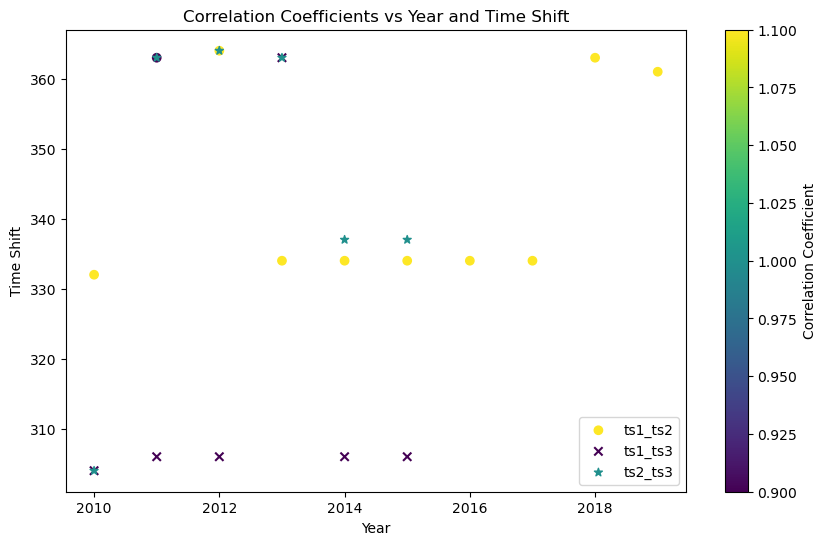

In [188]:
# Create a scatter plot
plt.figure(figsize=(10, 6))

col_arr =  np.unique(['_'.join(col.split('_')[:-1]) for col in result_df.columns.to_list()]) # pairs

# Loop through each pair of time series
for i, pair in enumerate(col_arr):
    correlation_data = result_df[f'{pair}_Correlation']
    shift_data = result_df[f'{pair}_Shift']

    # Define symbol for this pair
    symbol = ['o', 'x', '*'][i]

    # Plot the data
    plt.scatter(result_df.index, shift_data, c=correlation_data, cmap='viridis', marker=symbol, label=f'{pair}')

# Add colorbar
cbar = plt.colorbar(label='Correlation Coefficient')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Time Shift')
plt.title('Correlation Coefficients vs Year and Time Shift')

# Add legend
plt.legend(loc='lower right')

# Show plot
plt.show()
